In [1]:
# 구글 드라이브 MOUNT
from google.colab import drive
drive.mount('/content/drive')

# github와 연동하고 싶은 폴더로 이동
%cd /content/drive/MyDrive/study_DL/Study_DL

Mounted at /content/drive
/content/drive/MyDrive/study_DL/Study_DL


# GAN 모델 생성
- generator(생성자) 네트워크는 (latent_dim,)크기의 벡터를 (32,32,3) 크기의 이미지로 매핑함
- discrminator(판별자) 네트워크는 (32,32,3) 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑함
- 생성자와 판별자를 연결하는 GAN 네트워크 만들기 gan(x) = discriminator(generater(x))
  - 잠재 공간의 벡터를 판별자의 평가로 매핑함
  - 판별자는 생성자가 잠재공간의 벡터를 디코딩한 것이 얼마나 현실적인지 평가함
- 진짜/가짜 레이블과 함께 판별자를 훈련함
- 생성자 훈련을 위해 gan의 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용함

## 모델 생성시 유의할 점
- 마지막 활성화함수로 다른 종류모델에서 널리 사용하는 sigmoid(0 ~ 1)가 아닌 tanh 함수를 사용함(-1 ~ 1)
- 무작위성은 모델을 견고하게 만들기 때문에, 판별자에게 드롭아웃/레이블에 랜덤 노이즈를 추가하는 방법을 사용
- 희소한 그래디언트(maxpooling연산, relu 활성화함수가 유도하게 됨)는 종종 바람직한 현상이긴 하지만, gan에서는 아님
  - 훈련을 방해할 수 있기 때문에 maxpooling 대신 stride 합성곱을 사용하여 다운샘플링하겠음
  - 그리고 relu함수 대신 leakyrelu(약간의 음수를 허용) 층을 사용하겠음
- 생성자에게 픽셀 공간을 균일하게 다루지못해서 생성된 이미지에서 체스판 모양이 종종 나타남
  - 생성자와 판별자에게 스트라이드 conv2dTranspose나 Conv2D를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기 사용하겠음

  https://blog.naver.com/PostView.naver?blogId=demian7607&logNo=222049667265&redirect=Dlog&widgetTypeCall=true&directAccess=false

## 생성자


In [ ]:
import keras
from keras.layers import *
import numpy as np

In [ ]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape = (latent_dim,))

# 16*16 크기의 128개 채널을 갖는 특성맵으로 변환
x = Dense(128*16*16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

# 채널 수 256로 변환
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

# 32*32로 업샘플링
x = Conv2DTranspose(256, 4, strides = 2, padding = 'same')(x)
x = LeakyReLU()(x)

# 합성곱층 추가
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

# 32*32 크기의 3개 채널 가지는 특성맵으로 변환
x = Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)

generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

## 판별자

In [ ]:
discriminator_input = Input(shape = (height, width, channels))

x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

# 드롭아웃 생성
x = Dropout(0.4)(x)

# 분류 층
x = Dense(1, activation = 'sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

In [ ]:
discriminator.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0008,
                                                           clipvalue = 1.0,
                                                           decay = 1e-8),
                      loss = 'binary_crossentropy')

# 그래디언트 클리핑
## 말 그대로 기울기 값을 자르는 것을 의미
## 기울기 폭주를 막기 위해 임계값을 넘지 않도록 값을 자름
## 다시 말해서 임계치만큼 크기를 감소시킴

## GAN
- GAN을 훈련하는 것은 generator의 가중치를 업데이트 하는 것
- 훈련하는 동안 판별자를 동결(가중치 훈련 x)하는 것이 아주 중요함

In [ ]:
discriminator.trainable = False

gan_input = Input(shape = (latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         6264579   
                                                                 
 model_1 (Functional)        (None, 1)                 790913    
                                                                 
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [ ]:
gan_optimizer = keras.optimizers.RMSprop(learning_rate = 0.0004,
                                         clipvalue = 1.0,
                                         decay = 1e-8)

gan.compile(optimizer = gan_optimizer,
            loss = 'binary_crossentropy')

# 데이터 불러오기

In [ ]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.datasets import cifar10

170498071/170498071 [==============================] - 3s 0us/step
(5000, 32, 32, 3)


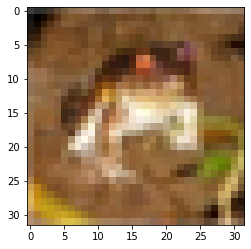

In [ ]:
# CIFAR10 데이터 로드

(x_train, y_train), (_,_) = cifar10.load_data()

# 개구리 이미지만 선택
x_train = x_train[y_train.flatten() == 6]

print(x_train.shape)
plt.imshow(x_train[0])

In [ ]:
# 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
x_train.shape

(5000, 32, 32, 3)

# 훈련

In [ ]:
iterations = 10000
batch_size = 20

save_dir = '../필요데이터/gan_images'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import array_to_img

In [ ]:
# 훈련 반복 시작


start = 0
for step in range(iterations):
  # 잠재 공간에서 무작위로 포인트 샘플링하기 with 정규분포
  random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

  # 가짜 이미지 디코딩
  generated_images = generator.predict(random_latent_vectors,verbose = 0)

  # 진짜 이미지와 연결
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])

  # 진짜와 가짜 이미지를 구분하여 레이블 합치기
  labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
  
  # 레이블에 랜덤 노이즈 추가
  labels += 0.05 * np.random.random(labels.shape)

  # 판별자 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # GAN 생성자 훈련부분: 생성자는 모두 진짜가 되게끔하는 것이 목적
  # 잠재공간에서 무작위로 포인트 샘플링함
  random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

  # 진짜 이미지 레이블 만들기
  misleading_targets = np.zeros((batch_size, 1))

  
  # 생성자 훈련
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  
  start += batch_size
  if start >len(x_train) - batch_size:
    start = 0

  #중간중간 저장하고 그래프 그리기
  if step % 100 == 0:
    # 모델 가중치 저장
    gan.save_weights('./save_model/230217_gan.h5')

    # 측정 지표 출력
    print(f'step: {step}')
    print(f'\t 판별자 손실: {d_loss}')
    print(f'\t 생성자 손실: {a_loss}')

    # 생성 이미지 하나 저장
    img = array_to_img(generated_images[0] * 255., scale = False )
    img.save(os.path.join(save_dir, f'{step}_generated_frog.png'))

    # 비교를 위해 진짜 이미지 하나 저장함
    img = array_to_img(real_images[0] * 255., scale = False )
    img.save(os.path.join(save_dir, f'{step}_real_frog.png'))

step: 0
	 판별자 손실: 0.7021419405937195
	 생성자 손실: 0.6690936088562012
step: 100
	 판별자 손실: 0.6500356793403625
	 생성자 손실: 0.8268898725509644
step: 200
	 판별자 손실: 0.6943843960762024
	 생성자 손실: 0.7183870077133179
step: 300
	 판별자 손실: 0.691900372505188
	 생성자 손실: 0.807476818561554
step: 400
	 판별자 손실: 0.7148979306221008
	 생성자 손실: 0.7262880206108093
step: 500
	 판별자 손실: 0.699691653251648
	 생성자 손실: 0.7496660351753235
step: 600
	 판별자 손실: 0.6933130025863647
	 생성자 손실: 0.7510568499565125
step: 700
	 판별자 손실: 0.7021424770355225
	 생성자 손실: 0.7490370869636536
step: 800
	 판별자 손실: 0.6900771856307983
	 생성자 손실: 0.7254374623298645
step: 900
	 판별자 손실: 0.7002527713775635
	 생성자 손실: 0.7404595613479614
step: 1000
	 판별자 손실: 0.6869365572929382
	 생성자 손실: 0.7483821511268616


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-a79fc09d05df>", line 46, in <module>
    gan.save_weights('./save_model/230217_gan.h5')
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.8/dist-packages/h5py/_hl/files.py", line 424, in __init__
    fid = make_fid(name, mode, userblock_size,
  File "/usr/local/lib/python3.8/dist-packages/h5py/_hl/files.py", line 196, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 116, in h5py.h5f.create
OSError: Unable to create file (unable to open file

OSError: ignored

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array

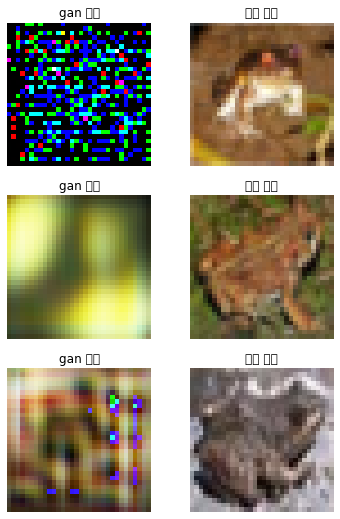

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6, 9))
for i in range(0,3):
  plt.subplot(3, 2, 2*i + 1)
  plt.imshow(load_img(f'{save_dir}/{i*100}_generated_frog.png'))
  plt.title('gan 생성')
  plt.axis('off')

  plt.subplot(3, 2, 2*i+2)
  plt.imshow(load_img(f'{save_dir}/{i*100}_real_frog.png'))
  plt.title('실제 그림')
  plt.axis('off')
plt.show()

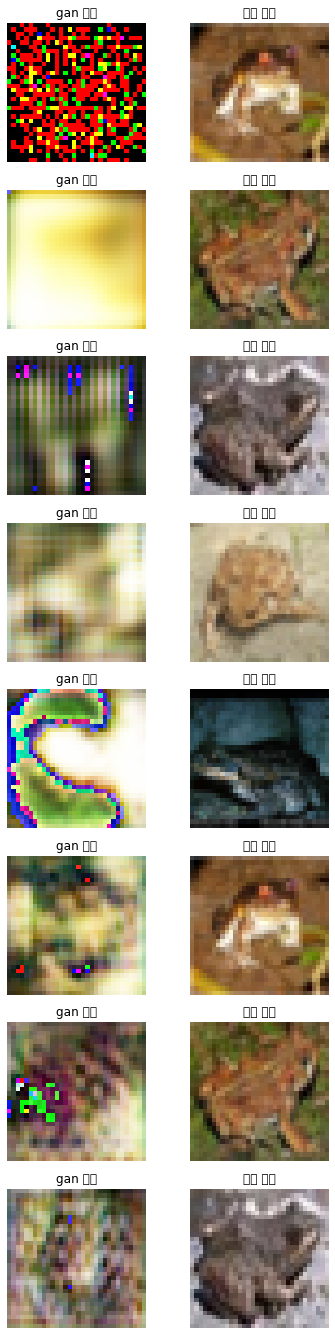

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

save_dir = '../필요데이터/gan_images'

plt.figure(figsize = (6, 24))
for i in range(0,8):
  plt.subplot(8, 2, 2*i + 1)
  plt.imshow(load_img(f'{save_dir}/{i*100}_generated_frog.png'))
  plt.title('gan 생성')
  plt.axis('off')

  plt.subplot(8, 2, 2*i+2)
  plt.imshow(load_img(f'{save_dir}/{i*100}_real_frog.png'))
  plt.title('실제 그림')
  plt.axis('off')
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47548 missing from current font.
  font.set_

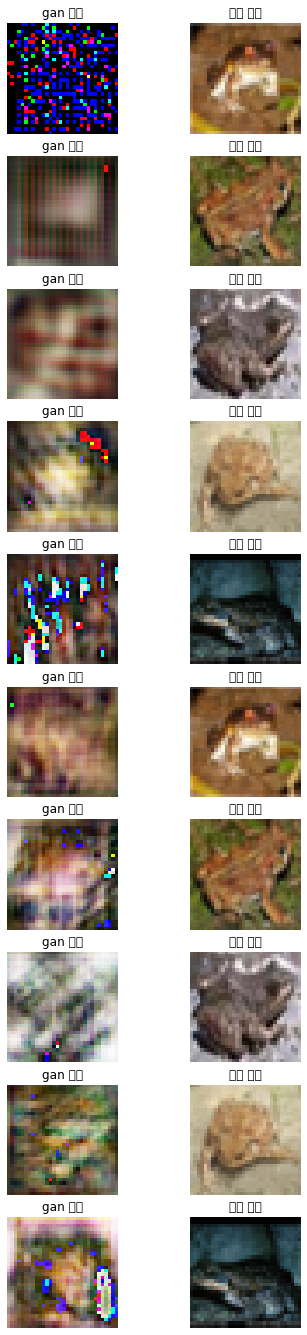

In [2]:
ssimport matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

save_dir = '../필요데이터/gan_images'

plt.figure(figsize = (6, 24))
for i in range(0,10):
  plt.subplot(10, 2, 2*i + 1)
  plt.imshow(load_img(f'{save_dir}/{i*100}_generated_frog.png'))
  plt.title('gan 생성')
  plt.axis('off')

  plt.subplot(10, 2, 2*i+2)
  plt.imshow(load_img(f'{save_dir}/{i*100}_real_frog.png'))
  plt.title('실제 그림')
  plt.axis('off')
plt.show()